In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from talib import RSI, BBANDS, MACD
#from datetime import datetime

#create a dataframe from json file in data directory
df_org = pd.read_json('data/2024-11-18.json')

def compute_average_ask_bid(price_data):
    if( price_data['Ask'] is not None and price_data['Bid'] is not None):
        return (price_data['Ask'] + price_data['Bid']) / 2
    else:
        return None

df_org['openPrices'] = [compute_average_ask_bid(OpenPrice) for OpenPrice in df_org["OpenPrice"]];
df_org['highPrices'] = [compute_average_ask_bid(HighPrice) for HighPrice in df_org["HighPrice"]];
df_org['lowPrices'] = [compute_average_ask_bid(LowPrice) for LowPrice in df_org["LowPrice"]];
df_org['closedprices'] = [compute_average_ask_bid(closedprice) for closedprice in df_org["ClosePrice"]];

## Drop rows with None values
df_org.dropna(subset=['closedprices', 'highPrices', 'lowPrices', 'openPrices'], inplace=True)


# Compute olhc4
df_org['olhc4'] = (df_org['closedprices'] + df_org['highPrices'] + df_org['lowPrices'] + df_org['openPrices']) / 4
# Compute log returns
df_org['log_returns'] = np.log(df_org['olhc4'] / df_org['olhc4'].shift(1))

df_org['SnapshotTime'] = pd.to_datetime(df_org['SnapshotTime'], format='ISO8601')

df_org.head()

In [ ]:


plt.plot(df_org['log_returns'] )
plt.show()

In [ ]:
df_org.info()

In [ ]:

up, mid, low = BBANDS(df_org.olhc4, timeperiod=21, nbdevup=1.5, nbdevdn=1.5, matype=0)

In [ ]:
data = pd.DataFrame({'olhc4': df_org['olhc4'], 'upper': up, 'middle': mid, 'lower': low})

<Axes: title={'center': 'Bollinger Bands'}>

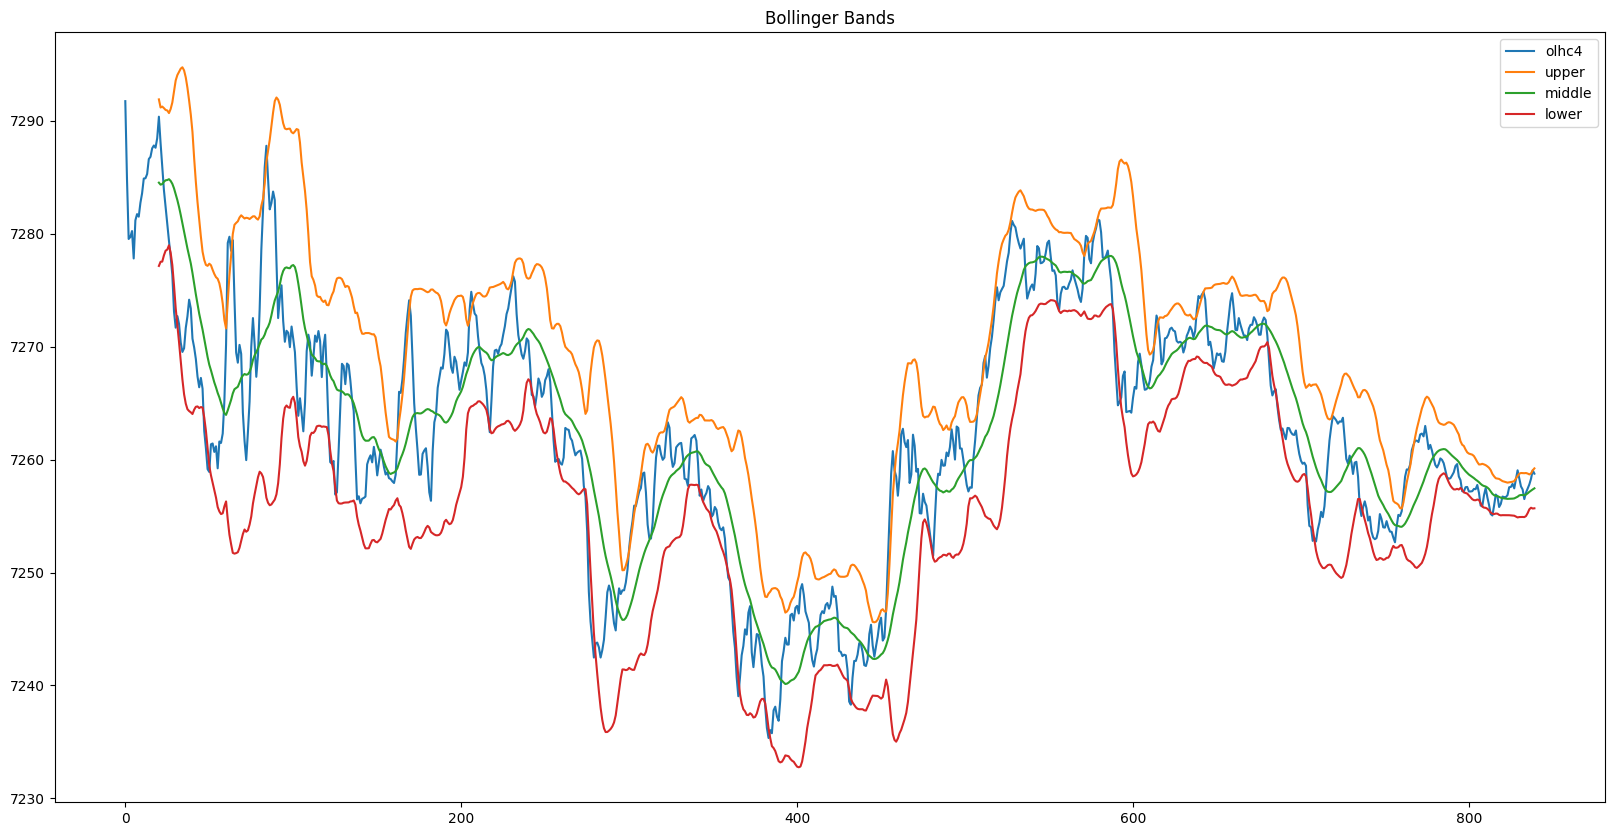

In [ ]:

data.plot(figsize=(20, 10), title='Bollinger Bands')


In [55]:
fig = go.Figure(data=[
    go.Candlestick(
                x=df_org['SnapshotTime'],
                open=df_org['openPrices'],
                high=df_org['highPrices'],
                low=df_org['lowPrices'],
                close=df_org['closedprices']),
    go.Scatter(x = df_org['SnapshotTime'],
                         y = up,
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         name = 'upper band',
                         opacity = 0.5),
    go.Scatter(x = df_org['SnapshotTime'],
                         y = low,
                         line_color = 'gray',
                         line = {'dash': 'dash'},
                         fill = 'tonexty',
                         name = 'lower band',
                         opacity = 0.3)] )

fig.update_layout( width=1790, height=1000)
fig.show()